In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Training
Iteration 0: with minibatch training loss = 7.62 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.95 and accuracy of 0.25
Iteration 200: with minibatch training loss = 1.43 and accuracy of 0.44
Iteration 300: with minibatch training loss = 1.37 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.29 and accuracy of 0.55
Iteration 500: with minibatch training loss = 1.23 and accuracy of 0.53
Iteration 600: with minibatch training loss = 1.19 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.24 and accuracy of 0.53
Epoch 1, Overall loss = 1.47 and accuracy of 0.469


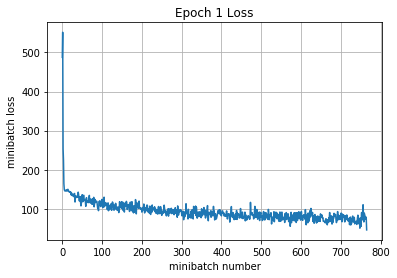

Validation
Epoch 1, Overall loss = 1.14 and accuracy of 0.579


In [8]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [5]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    
    #con-relu-batchnorm-conv-relu-batchnorm-pool 
    conv1 = tf.layers.conv2d(
        inputs=X,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm1 = tf.layers.batch_normalization(inputs=conv1,axis=1)
    
    
    conv2 = tf.layers.conv2d(
        inputs=batchnorm1,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm2 = tf.layers.batch_normalization(inputs=conv2,axis=1)
    
    pool1 = tf.layers.max_pooling2d(inputs=batchnorm2,pool_size=[2,2],strides=2)
    
    
    
    
   #con-relu-batchnorm-conv-relu-batchnorm-pool 
    conv3 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm3 = tf.layers.batch_normalization(inputs=conv3,axis=1)
    
    
    conv4 = tf.layers.conv2d(
        inputs=batchnorm3,
        filters=64,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm4 = tf.layers.batch_normalization(inputs=conv4,axis=1)
    
    pool2 = tf.layers.max_pooling2d(inputs=batchnorm4,pool_size=[2,2],strides=2)
    
     
    #con-relu-batchnorm-conv-relu-batchnorm-pool 
    
    conv5 = tf.layers.conv2d(
        inputs=pool2,
        filters=128,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm5 = tf.layers.batch_normalization(inputs=conv5,axis=1)
    
    
    conv6 = tf.layers.conv2d(
        inputs=batchnorm5,
        filters=128,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    batchnorm6 = tf.layers.batch_normalization(inputs=conv6,axis=1)

    pool3 = tf.layers.max_pooling2d(inputs=batchnorm6,pool_size=[2,2],strides=2)
    
    
    #dense layer
    pool3_flat = tf.reshape(pool3,[-1,2048])
    dense1 = tf.layers.dense(inputs=pool3_flat,units=1024,activation=tf.nn.relu)
    

    dropout1 = tf.layers.dropout(inputs=dense1,rate=0.5,training= is_training is not None)
    
    #logits
    logits = tf.layers.dense(inputs=dropout1,units=10)
    
    return logits

    
    pass

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(1e-3)


pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 9.37 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.77 and accuracy of 0.33
Iteration 200: with minibatch training loss = 1.36 and accuracy of 0.56
Iteration 300: with minibatch training loss = 1.4 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1.21 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.36 and accuracy of 0.52
Iteration 600: with minibatch training loss = 1.03 and accuracy of 0.66
Iteration 700: with minibatch training loss = 1.11 and accuracy of 0.66
Epoch 1, Overall loss = 1.44 and accuracy of 0.484


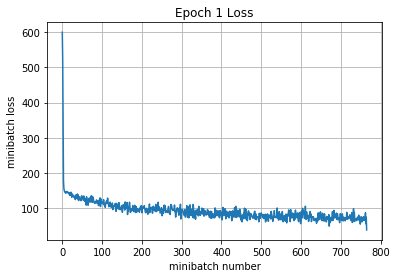

Iteration 800: with minibatch training loss = 1.17 and accuracy of 0.55
Iteration 900: with minibatch training loss = 0.921 and accuracy of 0.69
Iteration 1000: with minibatch training loss = 0.973 and accuracy of 0.59
Iteration 1100: with minibatch training loss = 0.932 and accuracy of 0.7
Iteration 1200: with minibatch training loss = 0.699 and accuracy of 0.77
Iteration 1300: with minibatch training loss = 0.911 and accuracy of 0.64
Iteration 1400: with minibatch training loss = 0.874 and accuracy of 0.66
Iteration 1500: with minibatch training loss = 1.21 and accuracy of 0.59
Epoch 2, Overall loss = 0.957 and accuracy of 0.662


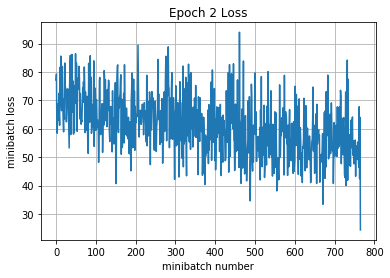

Iteration 1600: with minibatch training loss = 0.926 and accuracy of 0.66
Iteration 1700: with minibatch training loss = 0.893 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 0.544 and accuracy of 0.8
Iteration 1900: with minibatch training loss = 0.691 and accuracy of 0.72
Iteration 2000: with minibatch training loss = 0.758 and accuracy of 0.8
Iteration 2100: with minibatch training loss = 0.87 and accuracy of 0.7
Iteration 2200: with minibatch training loss = 0.738 and accuracy of 0.78
Epoch 3, Overall loss = 0.77 and accuracy of 0.73


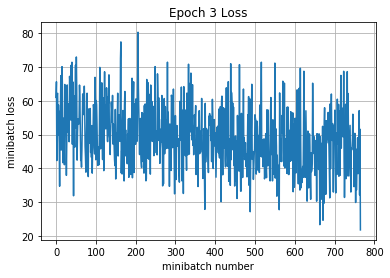

Iteration 2300: with minibatch training loss = 0.497 and accuracy of 0.84
Iteration 2400: with minibatch training loss = 0.934 and accuracy of 0.7
Iteration 2500: with minibatch training loss = 0.732 and accuracy of 0.75
Iteration 2600: with minibatch training loss = 0.647 and accuracy of 0.75
Iteration 2700: with minibatch training loss = 0.578 and accuracy of 0.77
Iteration 2800: with minibatch training loss = 0.697 and accuracy of 0.8
Iteration 2900: with minibatch training loss = 0.644 and accuracy of 0.77
Iteration 3000: with minibatch training loss = 0.533 and accuracy of 0.83
Epoch 4, Overall loss = 0.651 and accuracy of 0.771


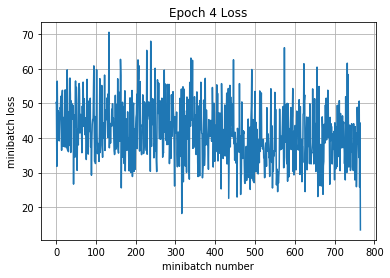

Iteration 3100: with minibatch training loss = 0.713 and accuracy of 0.77
Iteration 3200: with minibatch training loss = 0.563 and accuracy of 0.73
Iteration 3300: with minibatch training loss = 0.598 and accuracy of 0.8
Iteration 3400: with minibatch training loss = 0.619 and accuracy of 0.8
Iteration 3500: with minibatch training loss = 0.614 and accuracy of 0.8
Iteration 3600: with minibatch training loss = 0.573 and accuracy of 0.78
Iteration 3700: with minibatch training loss = 0.492 and accuracy of 0.78
Iteration 3800: with minibatch training loss = 0.553 and accuracy of 0.8
Epoch 5, Overall loss = 0.566 and accuracy of 0.801


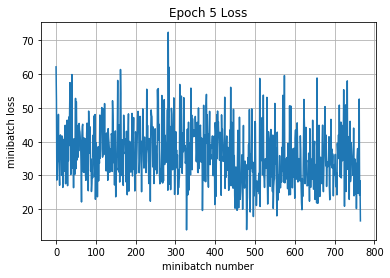

Iteration 3900: with minibatch training loss = 0.702 and accuracy of 0.75
Iteration 4000: with minibatch training loss = 0.572 and accuracy of 0.78
Iteration 4100: with minibatch training loss = 0.334 and accuracy of 0.86
Iteration 4200: with minibatch training loss = 0.347 and accuracy of 0.86
Iteration 4300: with minibatch training loss = 0.328 and accuracy of 0.86
Iteration 4400: with minibatch training loss = 0.61 and accuracy of 0.78
Iteration 4500: with minibatch training loss = 0.818 and accuracy of 0.78
Epoch 6, Overall loss = 0.487 and accuracy of 0.829


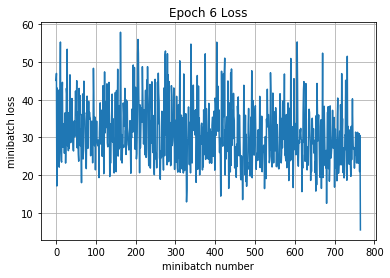

Iteration 4600: with minibatch training loss = 0.488 and accuracy of 0.83
Iteration 4700: with minibatch training loss = 0.385 and accuracy of 0.86
Iteration 4800: with minibatch training loss = 0.498 and accuracy of 0.81
Iteration 4900: with minibatch training loss = 0.476 and accuracy of 0.86
Iteration 5000: with minibatch training loss = 0.54 and accuracy of 0.8
Iteration 5100: with minibatch training loss = 0.311 and accuracy of 0.88
Iteration 5200: with minibatch training loss = 0.539 and accuracy of 0.83
Iteration 5300: with minibatch training loss = 0.387 and accuracy of 0.88
Epoch 7, Overall loss = 0.419 and accuracy of 0.851


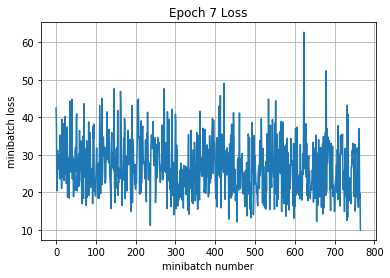

Iteration 5400: with minibatch training loss = 0.364 and accuracy of 0.88
Iteration 5500: with minibatch training loss = 0.47 and accuracy of 0.88
Iteration 5600: with minibatch training loss = 0.314 and accuracy of 0.94
Iteration 5700: with minibatch training loss = 0.324 and accuracy of 0.89
Iteration 5800: with minibatch training loss = 0.344 and accuracy of 0.86
Iteration 5900: with minibatch training loss = 0.329 and accuracy of 0.88
Iteration 6000: with minibatch training loss = 0.508 and accuracy of 0.84
Iteration 6100: with minibatch training loss = 0.447 and accuracy of 0.88
Epoch 8, Overall loss = 0.37 and accuracy of 0.869


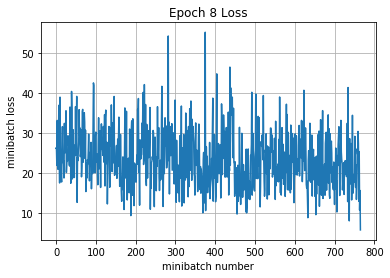

Iteration 6200: with minibatch training loss = 0.329 and accuracy of 0.84
Iteration 6300: with minibatch training loss = 0.197 and accuracy of 0.94
Iteration 6400: with minibatch training loss = 0.319 and accuracy of 0.88
Iteration 6500: with minibatch training loss = 0.235 and accuracy of 0.92
Iteration 6600: with minibatch training loss = 0.457 and accuracy of 0.89
Iteration 6700: with minibatch training loss = 0.145 and accuracy of 0.95
Iteration 6800: with minibatch training loss = 0.141 and accuracy of 0.97
Epoch 9, Overall loss = 0.311 and accuracy of 0.891


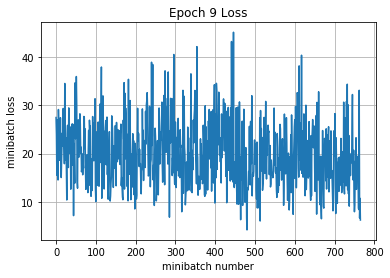

Iteration 6900: with minibatch training loss = 0.437 and accuracy of 0.81
Iteration 7000: with minibatch training loss = 0.216 and accuracy of 0.92
Iteration 7100: with minibatch training loss = 0.196 and accuracy of 0.94
Iteration 7200: with minibatch training loss = 0.226 and accuracy of 0.92
Iteration 7300: with minibatch training loss = 0.156 and accuracy of 0.91
Iteration 7400: with minibatch training loss = 0.319 and accuracy of 0.91
Iteration 7500: with minibatch training loss = 0.27 and accuracy of 0.89
Iteration 7600: with minibatch training loss = 0.227 and accuracy of 0.89
Epoch 10, Overall loss = 0.27 and accuracy of 0.904


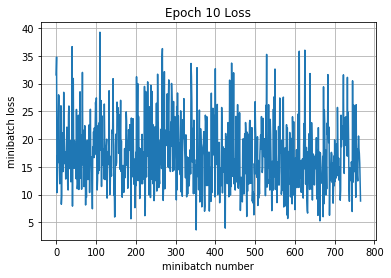

Validation
Epoch 1, Overall loss = 0.963 and accuracy of 0.75


(0.96290622520446778, 0.75)

In [6]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [7]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.278 and accuracy of 0.905
Validation
Epoch 1, Overall loss = 0.96 and accuracy of 0.77


(0.9601798067092896, 0.77000000000000002)